Based on <em> Demonstration of maximum-likelihood reconstruction with SIRF <\em>

# Initial set-up

In [91]:
#%% make sure figures appears inline and animations works
%matplotlib inline

# Setup the working directory for the notebook
import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('PET', 'ML_reconstruction')

In [92]:
#%% Initial imports etc
import numpy
import scipy.stats
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil
from numba import njit, prange
#import scipy
#from scipy import optimize
import sirf.STIR as pet
import sirf.Reg as reg
from sirf.Utilities import examples_data_path
from sirf_exercises import exercises_data_path

# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

In [93]:
# set-up redirection of STIR messages to files
msg_red = pet.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

In [94]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

def make_positive(image_array):
    """truncate any negatives to zero"""
    image_array[image_array<0] = 0
    return image_array

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = pet.TruncateToCylinderProcessor()
    filter.apply(image)

## Create some simulated data from ground-truth images
This is a repetition of the code in the OSEM notebook, just such that the current notebook is self-contained. However, there are no explanations here.

You should be able to adapt the notebook to use your own data as well of course. The actual reconstruction exercises and its evaluation does not require that the input is a simulation.

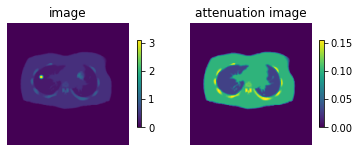

In [95]:
#%% Read in images
image = pet.ImageData(os.path.join(data_path, 'emission.hv'))*0.05
attn_image = pet.ImageData(os.path.join(data_path, 'attenuation.hv'))
template = pet.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))
plt.figure()
plot_2d_image([1,2,1], image.as_array()[0,:], "image")
plot_2d_image([1,2,2], attn_image.as_array()[0,:], "attenuation image")
plt.show()

In [96]:
#%% save max for future displays
cmax = image.max()*.6

We are going to start creating our detector model. A PET (or SPECT or CT or...) acquisition process is characterised by a system matrix, $\mathcal{A}$, as well as additive contributions consisting of scatter and random coincidences:
$$f = \mathcal{A}u + s + r $$
Wwhere $f$ is our data, $u$ is our image and $s,r$ are our additive componatnts. We will only model the system matrix in this notebook.

Now, our system model is itself comprised of a number of different operations. We will concentrate on three of these: the radon transform, $\mathcal{R}$, attenuation, $A$, and detector normalisation $\mathcal{N}$, giving us:
$$ \mathcal{A} \approx \mathcal{N} A \mathcal{R} $$
where attenuation corrections and normalisation and multiplicative factors in the projection domain. \
And so our next job is to use SIRF's software to build this acquisition model

In [97]:
# create acquisition model matrix (this uses something called ray tracing, which you can ignore for this example)
# This is a 3-D (or in our case 2-D) Radon Transform matrix
acq_model_matrix  = pet.RayTracingMatrix()
# we will increase the number of rays used for every Line-of-Response (LOR) as an example
# (it is not required for the exercise of course)
acq_model_matrix.set_num_tangential_LORs(5)
# We can now create the acquisition model using this matrix
acq_model = pet.AcquisitionModelUsingMatrix(acq_model_matrix)

And we have $\mathcal{A} \approx \mathcal{R} $ 

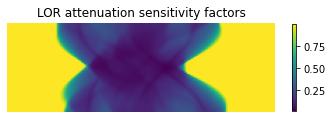

In [98]:
# We will now create the acquisition sensitivity model - a sinogram containing the sensitivity of each LOR. T
# This will depend on individual detector efficiencies, the geometry of the scanner, and the attenuation image
acq_model_for_attn = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell
# We now create the sensitivity model using the acquisition model and the attenuation image
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
# we can now find the attenuation sensitivity factors for each LOR by forward projecting a uniform image.
# We can set the value of this uniform image to be our detector efficiency. For now, let's just use 1.
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
plt.figure()
plot_2d_image([1,1,1], attn_factors.as_array()[0,0,:], "LOR attenuation sensitivity factors")

This "image" looks a bit funny. Hopefully you've done some reading into this already, but this is what's know as a sinogram (because of the sinusoidal shape) and consists of 2D views of the object from different angles stacked on top of eachother.

This particular sinogram is showing the sensitivity for each line of response between two detectors due to the attenuation of the object for imaging

In [99]:
# And so let's use this in our sensitivity model
asm_attn = pet.AcquisitionSensitivityModel(attn_factors)

In [100]:
# And then add the detector sensitivity (based on the attenuation image) that we made previously
acq_model.set_acquisition_sensitivity(asm_attn)
# set-up
acq_model.set_up(template,image)

And we now have $\mathcal{A} \approx \mathcal{N} A \mathcal{R} $. 

We can then see how this system will forward project our image and use this to simulate some data

no additive term added
applying unnormalisation...ok
no background term added


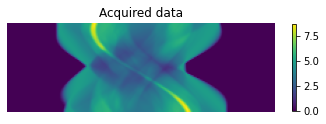

In [101]:
#%% simulate some data using forward projection
acquired_data=acq_model.forward(image)
plot_2d_image([1,1,1], acquired_data.as_array()[0,0,:], "Acquired data")

In [102]:
def add_noise(proj_data,noise_factor = 0.1, seed = 50):
    """Add Poission noise to acquisition data."""
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    numpy.random.seed(seed)
    noisy_proj_data_arr = numpy.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr*noise_factor);
    return noisy_proj_data

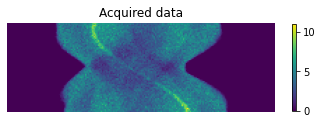

In [103]:
acquired_data = add_noise(acquired_data)
plot_2d_image([1,1,1], acquired_data.as_array()[0,0,:], "Acquired data")

OK and we have some simulated data. We have added poisson noise because of photon counting statistics where we either detect a count or we don't. An example of a poisson distribution with a mean of 2 and 10,000 counts is shown below

175.46736976785067

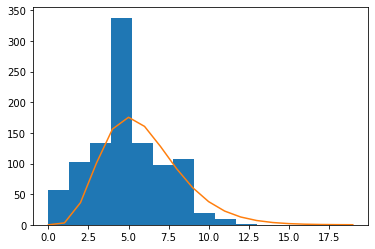

In [104]:
num_data = 1000
data = numpy.random.poisson(5, num_data)
poisson_fit = scipy.stats.poisson.pmf(5, numpy.arange(0, 20))*num_data
plt.hist(data)
plt.plot(poisson_fit)
numpy.max(poisson_fit)

Now, back to our sensitivity image. We can either treat our sensitivity such that we correct in the projection data space as above or we can correct in our image space:
$$ \mathcal{A} = \mathcal{R} A \mathcal{N} $$

This sensitivity image will look like the backprojection of a uniform sinogram of ones

applying unnormalisation...ok
backprojecting...ok


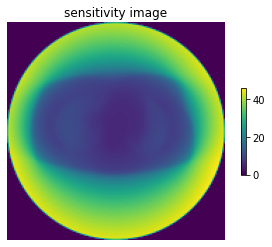

In [105]:
sens_image = acq_model.backward(template.get_uniform_copy(1))
plot_2d_image([1,1,1], sens_image.as_array()[0,:], "sensitivity image")

Now, lets have a look at what can happen to our sensitivity image (or attenuation factors) if we have a misaligned object

In [106]:
s_geom_info = attn_image.get_geometrical_info()
A_LPH = s_geom_info.get_index_to_physical_point_matrix()  # 4x4 affine matrix

/home/sam/devel/build/INSTALL/python/sirf/SIRF.py:704: UserWarning: geometrical info for STIR.ImageData might be incorrect
  warnings.warn("geometrical info for STIR.ImageData might be incorrect")


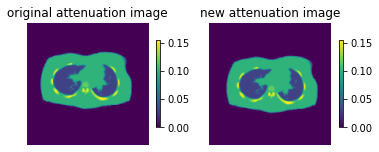

In [107]:
vol = attn_image.as_array()

vol_new = numpy.roll(vol, 5, axis = 1)
vol_new = numpy.roll(vol_new, 5, axis = 2)
attn_image_new = attn_image.clone().fill(vol_new)


plt.figure()
plot_2d_image([1,2,1], attn_image.as_array()[0,:], "original attenuation image")
plot_2d_image([1,2,2], attn_image_new.as_array()[0,:], "new attenuation image")
plt.show()

In [108]:
acq_model_for_attn_new = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell
# We now create the sensitivity model using the acquisition model and the attenuation image
asm_attn_new = pet.AcquisitionSensitivityModel(attn_image_new, acq_model_for_attn_new)
asm_attn_new.set_up(template)
attn_factors_new = asm_attn_new.forward(template.get_uniform_copy(1))
# And then add the detector sensitivity (based on the attenuation image) that we made previously
acq_model_new = pet.AcquisitionModelUsingRayTracingMatrix()
acq_model_new.set_acquisition_sensitivity(asm_attn_new)
# set-up
acq_model_new.set_up(template,image)
sens_image_new = acq_model_new.backward(template.get_uniform_copy(1))

applying unnormalisation...ok
backprojecting...ok


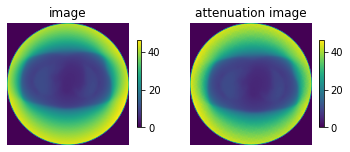

In [109]:
plt.figure()
plot_2d_image([1,2,1], sens_image.as_array()[0,:], "image")
plot_2d_image([1,2,2], sens_image_new.as_array()[0,:], "attenuation image")
plt.show()

Now let's compare a few reconstructions with our old and new sensitivity images. We'll use a home-made OSEM to highlight this

Firstly, let's write a quick function to deal with zero division errors outsiude of the FoV. We're using a parallel programming functionality called numba. This can be ignored. We're just setting pixels outside the FoV to zero

In [110]:
def sensitivity_division(arr1, arr2):
    tmp  = numpy.zeros_like(arr1).flatten()
    for i in prange(tmp.size):
        if arr2.flatten()[i] != 0:
            tmp[i] = arr1.flatten()[i]/arr2.flatten()[i]
        else:
            tmp[i] = 0
    return tmp.reshape(arr1.shape)

Next we'll create a function to perform a step of the Maximum Likelihood Expectation Maximisation

In [111]:
def MLEM_step(input_image, acq_model, acquired_data, sensitivity_image_array):
    output_image = input_image.clone()
    # forward projection
    forward_projected_data = acq_model.forward(input_image)
    # divide acquired data by forward projected data
    ratio = acquired_data / forward_projected_data
    # back projection
    back_projected_data = acq_model.backward(ratio).as_array()
    # divide by sensitivity image
    back_projected_data_array = sensitivity_division(back_projected_data, sensitivity_image_array)
    # update input image
    output_image = input_image*input_image.clone().fill(back_projected_data_array)
    return output_image


## create initial image

In the previous OSEM notebook, we just used a uniform image. Here, we will use a disk that roughly corresponds to the *Field of View (FOV)*. The reason for this is that it makes things easier for display and the gradient ascent code below.

An alternative solution would be to tell the `acq_model` to use a square FOV as opposed to a circular one, but that will slow down calculations just a little bit, so we won't do that here (feel free to try!).

In addition, the initial value is going to be a bit more important here as we're going to plot the value of the objective function. Obviously, having a descent estimate of the scale of the image will make that plot look more sensible. Feel free to experiment with the value!

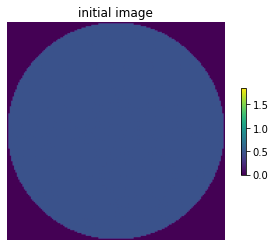

In [112]:
initial_image=image.get_uniform_copy(cmax / 4)
make_cylindrical_FOV(initial_image)
# display
im_slice = initial_image.dimensions()[0] // 2
plt.figure()
plot_2d_image([1,1,1],initial_image.as_array()[im_slice,:,:], 'initial image',[0,cmax])

In [113]:
obj_fun = pet.make_Poisson_loglikelihood(acquired_data)
obj_fun.set_acquisition_model(acq_model)
obj_fun.set_acquisition_data(acquired_data)
obj_fun.set_up(image)

In [114]:
radon_transform = pet.AcquisitionModelUsingRayTracingMatrix()
radon_transform.set_up(template, image)

In [115]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images = numpy.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data, sens_image.as_array())
    # store results
    obj_fun_value = obj_fun.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images[i,:,:,:] =  current_image.as_array()

no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied


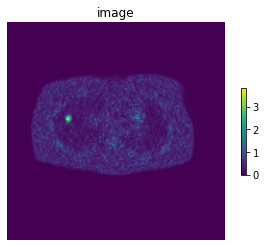

In [116]:
plot_2d_image([1,1,1], all_osem_images[-1][0,:], "image")

## Make some plots with these results

In [117]:
#%% define a function for plotting images and the updates
def plot_progress(all_images, title, subiterations = []):
    if len(subiterations) == 0:
        num_subiters = all_images[0].shape[0] - 1
        subiterations = range(1, num_subiters + 1)
    num_rows = len(all_images)

    for i in subiterations:
        plt.figure()
        for r in range(num_rows):
            plot_2d_image([num_rows,2,2 * r + 1],
                          all_images[r][i,im_slice,:,:],'%s at %d' % (title[r], i), [0,cmax])
            plot_2d_image([num_rows,2,2*r+2],
                          all_images[r][i,im_slice,:,:]-all_images[r][i - 1,im_slice,:,:],'update',[-cmax*.05,cmax*.05], cmap='seismic')
        #plt.pause(.05)
        plt.show()

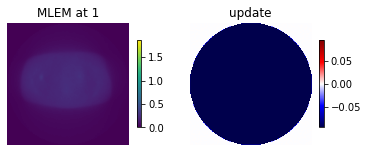

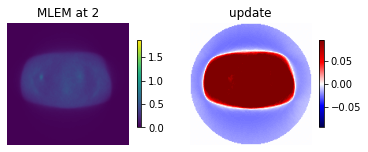

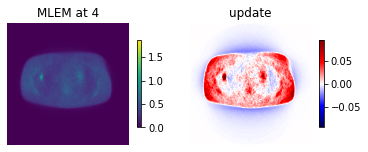

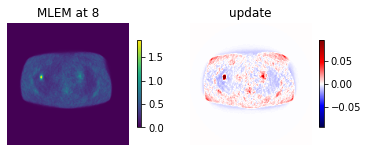

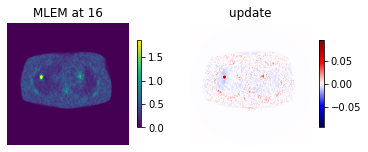

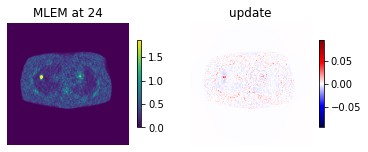

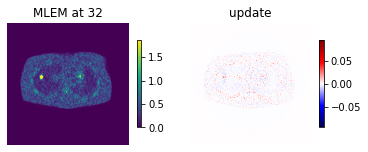

In [118]:
#%% now call this function to see how we went along
# note that in the notebook interface, this might create a box with a vertical slider
subiterations = (1,2,4,8,16,24,32)
# close all "open" images as otherwise we will get warnings (the notebook interface keeps them "open" somehow)
plt.close('all')    
plot_progress([all_osem_images], ['MLEM'],subiterations)

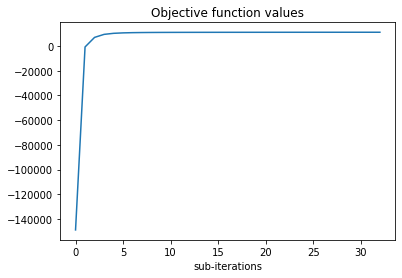

In [119]:
#%% plot objective function values
plt.figure()
#plt.plot(subiterations, [ osem_objective_function_values[i] for i in subiterations])
plt.plot(osem_objective_function_values)
plt.title('Objective function values')
plt.xlabel('sub-iterations');

The above plot seems to indicate that (OS)EM converges to a stable value of the
log-likelihood very quickly. However, as we've seen, the images are still changing.

Convince yourself that the likelihood is still increasing (either by zooming into the figure, or by using `plt.ylim`).

We can compute some simple ROI values as well. Let's plot those.

You might want to convince yourself first that these ROI are in the correct place (but it doesn't matter too much for this exercise).

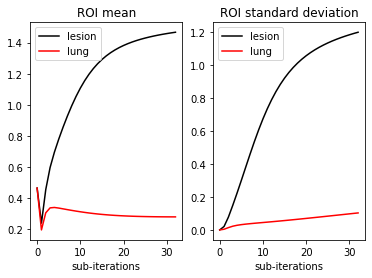

In [120]:
#%% ROI
ROI_lesion = all_osem_images[:,(im_slice,), 65:70, 40:45]
ROI_lung = all_osem_images[:,(im_slice,), 75:80, 45:50]

ROI_mean_lesion = ROI_lesion.mean(axis=(1,2,3))
ROI_std_lesion = ROI_lesion.std(axis=(1,2,3))

ROI_mean_lung = ROI_lung.mean(axis=(1,2,3))
ROI_std_lung = ROI_lung.std(axis=(1,2,3))

plt.figure()
#plt.hold('on')
plt.subplot(1,2,1)
plt.plot(ROI_mean_lesion,'k',label='lesion')
plt.plot(ROI_mean_lung,'r',label='lung')
plt.legend()
plt.title('ROI mean')
plt.xlabel('sub-iterations')
plt.subplot(1,2,2)
plt.plot(ROI_std_lesion, 'k',label='lesion')
plt.plot(ROI_std_lung, 'r',label='lung')
plt.legend()
plt.title('ROI standard deviation')
plt.xlabel('sub-iterations');

[]

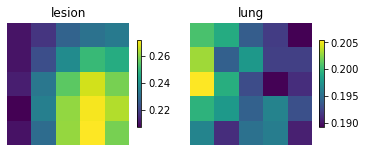

In [121]:
plt.figure()
plot_2d_image([1,2,1], ROI_lesion[1][0,:], "lesion")
plot_2d_image([1,2,2], ROI_lung[1][0,:], "lung")
plt.plot()

OK. so let's now compare this to a reconstruction with the offset sensitivity iamge

In [122]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_new = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_new = numpy.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_new[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data, sens_image_new.as_array())
    # store results
    obj_fun_value = obj_fun.value(current_image)
    osem_objective_function_values_new.append(obj_fun_value)
    all_osem_images_new[i,:,:,:] =  current_image.as_array()

no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied


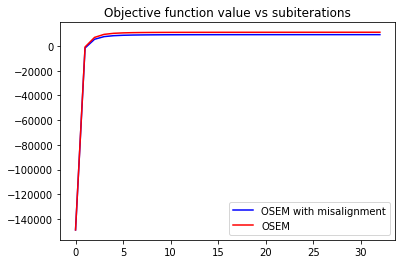

In [123]:
#%% Plot objective function values
plt.figure()
#plt.hold('on')
plt.title('Objective function value vs subiterations')
plt.plot(osem_objective_function_values_new,'b')
plt.plot(osem_objective_function_values,'r')
plt.legend(('OSEM with misalignment', 'OSEM'),loc='lower right');

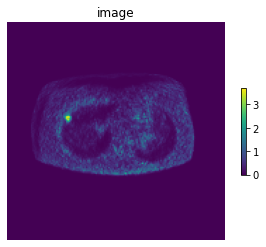

In [124]:
plot_2d_image([1,1,1], all_osem_images_new[-1][0,:], "image")

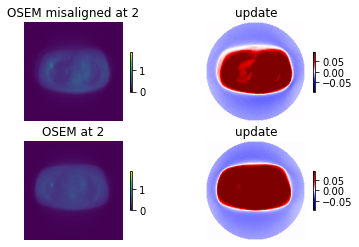

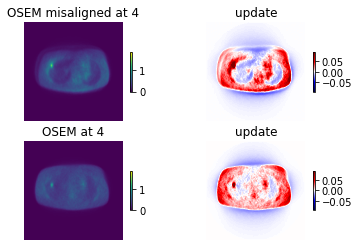

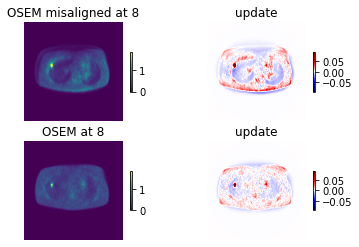

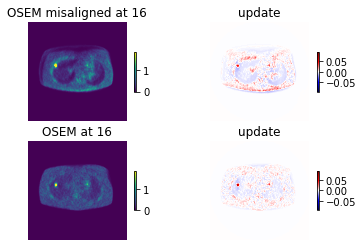

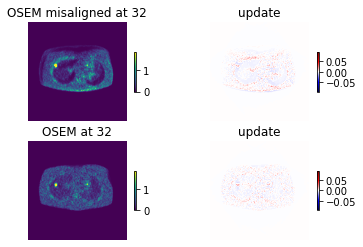

In [125]:
#%% compare GA and OSEM images
plot_progress([all_osem_images_new, all_osem_images], ['OSEM misaligned' ,'OSEM'],[2,4,8,16,32])

This has shown us that there can be a large deviation in reconstructed image if the sensitivity image is incorrect. So how can we fix this? One method is to `gate` our acquisition into groups of timepoint with similar attenuation maps (i.e patient positions). We can then calculate a sensitivity image for all these timepoints. However, this could lead to long calculation times.

We could therefore use a neural network to output a the required change in a sensitivity image based on the change in an attenuation image.

In [206]:
# Import a file that can generate the shepp logan phantom
from odl_funcs.ellipses import EllipsesDataset
# Import standard extra packages
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

size_xy = 128
mini_batch = 10
from sirf.Utilities import examples_data_path

In [207]:
train_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(acq_model.forward, image, mode="train") \
    , batch_size=mini_batch, shuffle=True)

In [208]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [239]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, chs=(512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [245]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512), dec_chs=(512, 256, 128, 64), num_class=1, retain_dim=True, out_sz=(155,155)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [241]:
enc_block = Block(1, 64)
x         = torch.randn(1, 1, 155, 155)
enc_block(x).shape

torch.Size([1, 64, 151, 151])

In [234]:
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 155, 155)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 151, 151])
torch.Size([1, 128, 71, 71])
torch.Size([1, 256, 31, 31])
torch.Size([1, 512, 11, 11])


In [240]:
decoder = Decoder()
x = torch.randn(1, 512, 11, 11)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 60, 60])

In [246]:
unet = UNet()
x    = torch.randn(1, 3, 155, 155)
unet(x).shape

torch.Size([1, 1, 155, 155])

In [247]:
unet(x)

tensor([[[[0.1176, 0.1176, 0.1176,  ..., 0.1280, 0.1038, 0.1038],
          [0.1176, 0.1176, 0.1176,  ..., 0.1280, 0.1038, 0.1038],
          [0.1176, 0.1176, 0.1176,  ..., 0.1280, 0.1038, 0.1038],
          ...,
          [0.1010, 0.1010, 0.1010,  ..., 0.1291, 0.1117, 0.1117],
          [0.1112, 0.1112, 0.1112,  ..., 0.1199, 0.1317, 0.1317],
          [0.1112, 0.1112, 0.1112,  ..., 0.1199, 0.1317, 0.1317]]]],
       grad_fn=<UpsampleNearest2DBackward1>)